In [1]:
# golden standard
import numpy as np
import os
import math
import torch
import torchvision
from torchvision import transforms



# laod MNIST
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
root = "/network/datasets/torchvision"
data = torchvision.datasets.MNIST(root, True, transform=transform)

# color it

In [2]:
# use hydra configs to load the dataset
import hydra
from utils import hydra_custom_resolvers
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
configs_path = "configs"
config_name = "train_root.yaml"

with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                
                            ],
                            return_hydra_config=True,
    )
    

    transform = transforms.Compose([hydra.utils.instantiate(t) for _, t in config.datamodule.transforms.items()])
    def renormalize():
        for _, t in config.datamodule.transforms.items():
            if "Standardize" in t["_target_"]:
                """Renormalize from [-1, 1] to [0, 1]."""
                return lambda x: x / 2.0 + 0.5
            
    # setup the dataset with the hydra config
    datamodule = hydra.utils.instantiate(config.datamodule, _recursive_=False)
    datamodule.prepare_data()
    datamodule.setup()

    # instantiate the model with hydra
    model = hydra.utils.instantiate(config.model, _recursive_=False)

renormalize = datamodule.renormalize()
iterator = iter(datamodule.test_dataloader())

/home/mila/s/sayed.mansouri-tehrani/.conda/envs/bb/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
next(iterator)[0].shape

torch.Size([256, 1, 28, 28])

In [6]:
model(next(iterator)[0]).shape

torch.Size([256, 1, 28, 28])

In [ ]:
datamodule.valid_dataset[0][0]

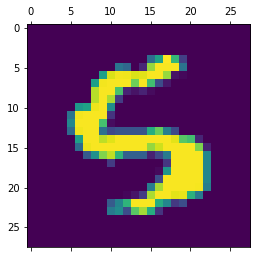

In [3]:
plt.matshow(datamodule.valid_dataset[0][0].squeeze())

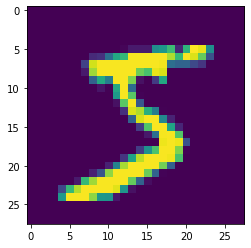

In [39]:
plt.imshow(data[0][0].squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


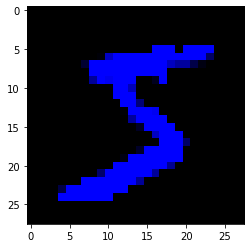

In [46]:
test_sample = data[0][0].permute(1,2,0).repeat(1, 1, 3)
test_sample
non_bg_pixels = test_sample[:, :, 0] > 0.0
# test_sample[non_bg_pixels, :] = test_sample[non_bg_pixels, :] * torch.tensor([1.0, 0.0, 0.0])
# test_sample[non_bg_pixels, :] = test_sample[non_bg_pixels, :] * torch.tensor([0.0, 1.0, 0.0])
test_sample[non_bg_pixels, :] = test_sample[non_bg_pixels, :] * torch.tensor([0.0, 0.0, 1.0])
test_sample[~non_bg_pixels, :] = torch.tensor([0.0, 0.0, 0.0])
plt.imshow(test_sample)
# should normalize again to be between -1,1 or -0.5 and 0.5
# plt.matshow(data[0][0].squeeze())

In [36]:
test_sample

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [27]:
data[0][0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

/home/mila/s/sayed.mansouri-tehrani/.conda/envs/bb/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:736: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.array(x, subok=True, copy=copy)


ValueError: only one element tensors can be converted to Python scalars

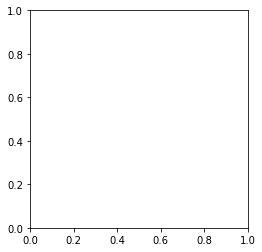

In [19]:
import matplotlib.pyplot as plt

plt.imshow(data[0][0])

In [15]:
type(data[0][0])

PIL.Image.Image

In [ ]:
# dataset for all properties

import hydra
from slot_based_disentanglement.utils import hydra_custom_resolvers
import torch
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import pickle
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
from itertools import product
import scipy
configs_path = "configs"
# config_name = "config.yaml"
config_name = "evaluate_root.yaml" # "dummy.yaml" # "evaluate_root.yaml"
# config_name = "train_root.yaml" # "dummy.yaml" # "evaluate_root.yaml"
from slot_based_disentanglement.utils.lp_solver import lp_solver_cvxpy, lp_solver_pulp


n_balls = 4
from slot_based_disentanglement.utils import hydra_custom_resolvers
with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                # "model=inertia_balls_saae_contrastive_recons",
                                # "model.encoder.slot_size=64",
                                # f"model.encoder.num_slots={n_balls+1}",
                                # "model.z_dim=2",
                                # "model.pl_model_ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/slot_attention_inertia_balls_autoencoder_2_cyclic_fixed-epoch\=1796-train_loss\=0.00-Linear_Disentanglement\=0.00-Permutation_Disentanglement\=0.00.ckpt",
                                # "ckpt_path=null",
                                # "datamodule=inertia_balls",
                                # "datamodule/dataset=all_properties_sparse_offset",
                                # "datamodule.dataset.signed=False",
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_3_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1-epoch\=394-train_loss\=0.18-Linear_Disentanglement\=0.37-Permutation_Disentanglement\=0.47.ckpt",
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_4_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1-epoch\=174-train_loss\=0.33-Linear_Disentanglement\=0.01-Permutation_Disentanglement\=0.04.ckpt",
                                # z_dim=4, z_dis=4
                                # "model.signed_change=False",
                                # "model.z_dim=4",
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_4_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1-epoch\=399-train_loss\=0.15-Linear_Disentanglement\=0.21-Permutation_Disentanglement\=0.27.ckpt"
                                
                                # z_dim=2, z_dis=2, load from ckpt
                                "model=inertia_balls_saae_contrastive_recons_ckpt",
                                f"model.num_slots={n_balls+1}",
                                "model.z_dim=2",
                                "+model.encoder_ckpt_path=null",
                                # frozen enc-dec
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_2_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1_z_dis_2-epoch\=399-train_loss\=0.00-Linear_Disentanglement\=0.99-Permutation_Disentanglement\=0.99.ckpt",
                                # finetuned enc-dec
                                "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_2_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1_z_dis_2-epoch\=399-train_loss\=0.01-Linear_Disentanglement\=1.00-Permutation_Disentanglement\=0.98.ckpt"

                                # z_dim=3, z_dis=3, load from ckpt
                                # "model=inertia_balls_saae_contrastive_recons_ckpt",
                                # f"model.num_slots={n_balls+1}",
                                # "model.z_dim=3",
                                # "+model.encoder_ckpt_path=null",
                                # frozen enc-dec
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_3_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1_z_dis_3-epoch\=399-train_loss\=0.97-Linear_Disentanglement\=0.66-Permutation_Disentanglement\=0.67.ckpt",
                                # finetuned enc-dec
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_3_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1_z_dis_3-epoch\=399-train_loss\=0.84-Linear_Disentanglement\=0.66-Permutation_Disentanglement\=0.67.ckpt",
                                
                                # z_dim=4, z_dis=4, load from ckpt
                                # "model=inertia_balls_saae_contrastive_recons_ckpt",
                                # f"model.num_slots={n_balls+1}",
                                # "model.z_dim=4",
                                # "+model.encoder_ckpt_path=null",
                                # frozen enc-dec
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_4_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1_z_dis_4-epoch\=299-train_loss\=1.31-Linear_Disentanglement\=0.50-Permutation_Disentanglement\=0.52.ckpt",
                                # finetuned enc-dec
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_4_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1_z_dis_4-epoch\=299-train_loss\=0.34-Linear_Disentanglement\=0.50-Permutation_Disentanglement\=0.46.ckpt",

                                # z_dim=3, z_dis=3, load from ckpt, position change + shape change (colour fixed)
                                # "model=inertia_balls_saae_contrastive_recons_ckpt",
                                # f"model.num_slots={n_balls+1}",
                                # "model.z_dim=3",
                                # "+model.encoder_ckpt_path=null",
                                # "ckpt_path=/home/mila/s/sayed.mansouri-tehrani/mechanism-based-disentanglement/disentanglement_by_mechanisms/SA_inertia_balls_contrastive_recons_zdim_3_n_balls_2_cyclic_fixed_argmin_known_mech_False_sparsity_1_z_dis_3-epoch\=16-train_loss\=1.26-Linear_Disentanglement\=0.66-Permutation_Disentanglement\=0.66.ckpt",

                            ],
                            return_hydra_config=True,
    )
    
    # model = hydra.utils.instantiate(config.model, _recursive_=False)

    from torchvision import transforms
    transform = transforms.Compose([hydra.utils.instantiate(t) for _, t in config.datamodule.transforms.items()])
    def renormalize():
        for _, t in config.datamodule.transforms.items():
            if "Standardize" in t["_target_"]:
                """Renormalize from [-1, 1] to [0, 1]."""
                return lambda x: x / 2.0 + 0.5
            
            # TODO: add more options if required

device = 'cuda'
# model.to(device)
renormalize = renormalize()

In [ ]:
n_balls = 3
z = np.zeros((n_balls, 6))
z[0, :2] = [0.5, 0.25]
z[1, :2] = [0., 0.4]
z[2, :2] = [0.25, 0.25]
# colour
z[0, 2] = 0
z[1, 2] = 1
z[2, 2] = 2
# shape
z[0, 3] = 0
z[1, 3] = 1
z[2, 3] = 2
# size
z[0, 4] = 0.1
z[1, 4] = 0.07
z[2, 4] = 0.1
# rotation angle
z[0, 5] = 0.0 # 0.2
z[1, 5] = -0.0 # 0.4
z[2, 5] = 0.0 # 0.4

hsv_colours = [COLOURS_[z[i,2].astype(int)] for i in range(z.shape[0])]
rgb_colours = [[255.*channel for channel in colorsys.hls_to_rgb(*c)] for c in hsv_colours]
x, seg_mask = draw_scene(z, rgb_colours)
x = transform(x)

In [ ]:
plt.figure()
plt.imshow(renormalize(x.permute(1,2,0)))
plt.figure()
plt.imshow(seg_mask[3])

In [1]:
# dataset for all properties

import hydra
from slot_based_disentanglement.utils import hydra_custom_resolvers
import torch
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import pickle
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
from itertools import product
import scipy
configs_path = "configs"
# config_name = "config.yaml"
config_name = "evaluate_root.yaml" # "dummy.yaml" # "evaluate_root.yaml"
# config_name = "train_root.yaml" # "dummy.yaml" # "evaluate_root.yaml"
from slot_based_disentanglement.utils.lp_solver import lp_solver_cvxpy, lp_solver_pulp


n_balls = 4
from slot_based_disentanglement.utils import hydra_custom_resolvers
with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                "datamodule=inertia_balls",
                                f"datamodule.n_balls={n_balls}",
                                f"datamodule.num_samples.train={10}",
                                f"datamodule.num_samples.valid={10}",
                                f"datamodule.num_samples.test={10}",
                                "datamodule/dataset=all_p_sparse_offset",
                                "datamodule.dataset.signed=True",
                                "datamodule.dataset.properties_list=['x','y','c','l','p']",
                                "datamodule.dataset.z_dim=5",
                            ],
                            return_hydra_config=True,
    )
    
    datamodule = hydra.utils.instantiate(config.datamodule, _recursive_=False)
    datamodule.prepare_data()
    datamodule.setup()

    from torchvision import transforms
    transform = transforms.Compose([hydra.utils.instantiate(t) for _, t in config.datamodule.transforms.items()])
    def renormalize():
        for _, t in config.datamodule.transforms.items():
            if "Standardize" in t["_target_"]:
                """Renormalize from [-1, 1] to [0, 1]."""
                return lambda x: x / 2.0 + 0.5
            
            # TODO: add more options if required

renormalize = datamodule.renormalize()
iterator = iter(datamodule.test_dataloader())

pygame 2.0.2 (SDL 2.0.16, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]
/home/mila/s/sayed.mansouri-tehrani/.conda/envs/bb/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
batch = next(iterator)

StopIteration: 

In [3]:
z1,z2 = batch["latents"]
x1,x2 = batch["images"]
s1,s2 = batch["segmentation_masks"]

In [14]:
print(x2.min())
print(x2.max())

tensor(-0.2863)
tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


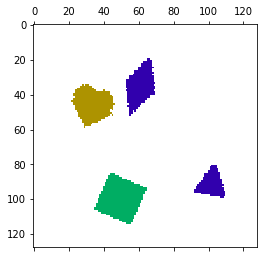

In [7]:
plt.matshow(x1[0].permute(1,2,0))

In [ ]:
n = 4
for i in range(n):
    plt.figure()
    plt.imshow(x1[i].permute(1,2,0))
    plt.figure()
    plt.imshow(x2[i].permute(1,2,0))
# for i in range(0,1):
#     for j in range(4):
#         plt.figure()
#         plt.imshow(s1[i][j])
#         plt.figure()
#         plt.imshow(s2[i][j])

In [ ]:
for i in range(0,5):
    plt.figure()
    plt.imshow(renormalize(x1[i].permute(1,2,0)))
    plt.figure()
    plt.imshow(renormalize(x2[i].permute(1,2,0)))

In [ ]:
num_samples = 5
print(z1[:num_samples, :2])
print(z1[:num_samples, 6:8])
print(f"--------------------======--------------------")
print(z2[:num_samples, :2])
print(z2[:num_samples, 6:8])
print(f"--------------------======--------------------")
print((z2[:num_samples]-z1[:num_samples]).reshape(num_samples, n_balls, -1))
print((np.linalg.norm(z2[:num_samples, :2]-z1[:num_samples, :2])))

In [ ]:
dists = np.linalg.norm(z1.reshape(z1.shape[0], -1, 6)[:num_samples, 0, :2]-z1.reshape(z1.shape[0], -1, 6)[:num_samples, 1, :2], ord=2, axis=1)
print(dists)
print(z1[:num_samples, 4] * 4)

In [ ]:
import numpy as np
import pygame
import os
from pygame import gfxdraw
import colorsys
import math


if "SDL_VIDEODRIVER" not in os.environ:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
    os.environ["SDL_AUDIODRIVER"] = "dsp"

# HSV colours
COLOURS_ = [
    [0.05, 0.6, 0.6],
    # [0.15, 0.6, 0.6],
    [0.25, 0.6, 0.6],
    # [0.35, 0.6, 0.6],
    [0.45, 0.6, 0.6],
    # [0.55, 0.6, 0.6],
    [0.65, 0.6, 0.6],
    # [0.75, 0.6, 0.6],
    [0.85, 0.6, 0.6],
    # [0.95, 0.6, 0.6],
]

SHAPES_ = [
    "circle",
    "square",
    "triangle",
    "heart"
]

SCREEN_DIM = 128
Y_SHIFT = 0.0

def draw_shape(
    x_,
    y_,
    surf,
    color=(204, 204, 0),
    radius=0.1,
    screen_width=SCREEN_DIM,
    y_shift=Y_SHIFT,
    offset=None,
    shape="circle",
    rotation_angle=0.
):
    if offset is None:
        offset = screen_width / 2
    scale = screen_width
    x = scale * x_ + offset
    y = scale * y_ + offset

    temp_surf = pygame.Surface((screen_width, screen_width), pygame.SRCALPHA)
    # temp_surf_rotation = pygame.Surface((screen_width, screen_width), pygame.SRCALPHA) # for rotations
    temp_surf_rotation = pygame.Surface((20, 20), pygame.SRCALPHA) # for rotations

    if shape == "circle":
        # pygame.draw.circle(surface=surf, color=color,
        #                center=(int(x), int(y - offset * y_shift)), radius=int(radius * scale))
        gfxdraw.aacircle(
            temp_surf_rotation, 0, 0, int(radius * scale), color
            )
        gfxdraw.filled_circle(
            temp_surf_rotation, 0, 0, int(radius * scale), color
        )

        # for segmentation mask
        gfxdraw.aacircle(
        temp_surf, 0, 0, int(radius * scale), color
            )
        gfxdraw.filled_circle(
            temp_surf, 0, 0, int(radius * scale), color
            )

    elif shape == "square":
        radius = int(radius * scale)*2
        pygame.draw.polygon(surface=temp_surf_rotation, color=color,
                        points=[(int(i), int(j)) for i, j in [(0,0), (radius,0), (radius,radius), (0,radius)]])
        # for segmentation mask
        pygame.draw.polygon(surface=temp_surf, color=color,
                        points=[(int(i), int(j)) for i, j in [(0,0), (radius,0), (radius,radius), (0,radius)]])

    elif shape == "triangle":
        radius = (radius * scale)*2
        # x, y = ((x) - radius/2, (y - offset * y_shift) - radius/2)
        pygame.draw.polygon(surface=temp_surf_rotation, color=color,
                        points=[(int(i), int(j)) for i, j in [(radius//2,radius), (radius,0), (0,0)]])
        # for segmentation mask
        pygame.draw.polygon(surface=temp_surf, color=color,
                        points=[(int(i), int(j)) for i, j in [(radius//2,radius), (radius,0), (0,0)]])

    elif shape == "heart":
        radius = (radius * scale)*2
        s = 3.4 # 3.5
        j = 1.33
        pygame.draw.circle(surface=temp_surf_rotation, color=color,
                    center=(int(3 * radius /(s * j)), int(radius/(s * j) + radius/2)), radius=int(radius/s))
        pygame.draw.circle(surface=temp_surf_rotation, color=color,
                    center=(int(radius/(s*j)), int(radius /(s*j) + radius/2)), radius=int(radius/s))
        pygame.draw.polygon(surface=temp_surf_rotation, color=color,
                        points=[(int(np.floor(i)), int(np.floor(j))) for i, j in [(2*radius/(s*j),0), (2 * radius/(s*j) - radius/2.0,radius/30 + radius/2), (2*radius/(s*j) + radius/2.0,radius/30 + radius/2)]])
        # for segmentation mask
        pygame.draw.circle(surface=temp_surf, color=color,
                    center=(int(3 * radius /(s * j)), int(radius/(s * j) + radius/2)), radius=int(radius/s))
        pygame.draw.circle(surface=temp_surf, color=color,
                    center=(int(radius/(s*j)), int(radius /(s*j) + radius/2)), radius=int(radius/s))
        pygame.draw.polygon(surface=temp_surf, color=color,
                        points=[(int(np.floor(i)), int(np.floor(j))) for i, j in [(2*radius/(s*j),0), (2 * radius/(s*j) - radius/2.0,radius/30 + radius/2), (2*radius/(s*j) + radius/2.0,radius/30 + radius/2)]])

    rotated_surf = pygame.Surface((screen_width, screen_width), pygame.SRCALPHA)
    # Rotate the temporary surface with the rectangle and blit it onto the new surface
    # rotated_surf.blit(pygame.transform.rotate(temp_surf_rotation, math.degrees(rotation_angle)), (0, 0))

    rotated_surf_rect = temp_surf_rotation.get_rect(center=(int(x), int(y)))
    
    rotated_fuck = pygame.transform.rotate(temp_surf_rotation, math.degrees(rotation_angle))
    rotated_surf_rect = rotated_fuck.get_rect(center=(int(x), int(y)))
    
    rotated_surf.blit(pygame.transform.rotate(temp_surf_rotation, math.degrees(rotation_angle)), rotated_surf_rect)
    surf.blit(rotated_surf, (0, 0))
    # rotated_surf.blit(pygame.transform.rotate(temp_surf_rotation, math.degrees(rotation_angle)), (int(x), int(y)))
    # surf.blit(rotated_surf, (int(x), int(y)))

    temp_surf_pos = (0,0)
    ball_mask = pygame.mask.from_surface(temp_surf)

    # mask -› surface
    new_temp_surf = ball_mask.to_surface()
    # do the same flip as the one occurring for the screen
    new_temp_surf = pygame.transform.flip(new_temp_surf, False, True)
    new_temp_surf.set_colorkey((0,0,0))

    return np.transpose(np.array(pygame.surfarray.pixels3d(new_temp_surf)), axes=(1, 0, 2))[:, :, :1] # [screen_width, screen_width, 1]
    
    # temp_surf_pos = (0,0)
    # ball_mask = pygame.mask.from_surface(temp_surf)

    # # mask -› surface
    # new_temp_surf = ball_mask.to_surface()
    # # do the same flip as the one occurring for the screen
    # new_temp_surf = pygame.transform.flip(new_temp_surf, False, True)
    # new_temp_surf.set_colorkey((0,0,0))

    # return np.transpose(np.array(pygame.surfarray.pixels3d(new_temp_surf)), axes=(1, 0, 2))[:, :, :1] # [screen_width, screen_width, 1]


In [ ]:
pygame.init()
screen_dim = 128
ball_rad = 0.08
screen = pygame.display.set_mode((screen_dim, screen_dim))
surf = pygame.Surface((screen_dim, screen_dim))

def draw_scene(z, colours=None, human_mode=True):
    global surf
    global screen
    surf.fill((255, 255, 255))
    bg_surf = pygame.Surface((screen_dim, screen_dim), pygame.SRCALPHA)

    obj_masks = []
    if z.ndim == 1:
        z = z.reshape((1, 2))
    if colours is None:
        colours = [COLOURS_[3]] * z.shape[0]
    for i in range(z.shape[0]):
        obj_masks.append(
            draw_shape(
                z[i, 0],
                z[i, 1],
                surf,
                color=colours[i],
                radius=z[i,4],
                screen_width=screen_dim,
                y_shift=0.0,
                offset=0.0,
                shape=SHAPES_[int(z[i,3])],
                rotation_angle=z[i,5]
            )
        )

        _ = draw_shape(
                z[i, 0],
                z[i, 1],
                bg_surf,
                color=colours[i],
                radius=z[i,4],
                screen_width=screen_dim,
                y_shift=0.0,
                offset=0.0,
                shape=SHAPES_[int(z[i,3])],
                rotation_angle=z[i,5]
            )

        bg_surf_pos = (0,0)
        bg_mask = pygame.mask.from_surface(bg_surf)
        bg_mask.invert() # so that mask bits for balls are cleared and the bg gets set.

        # mask -› surface
        new_bg_surf = bg_mask.to_surface()
        new_bg_surf.set_colorkey((0,0,0))
        # do the same flip as the one occurring for the screen
        new_bg_surf = pygame.transform.flip(new_bg_surf, False, True)

        # print(np.array(pygame.surfarray.pixels3d(new_bg_surf)).shape)
        # bg_mask = np.array(pygame.surfarray.pixels3d(new_bg_surf))[:, :, :1] # [screen_width, screen_width, 1]
        bg_mask = np.transpose(np.array(pygame.surfarray.pixels3d(new_bg_surf)), axes=(1, 0, 2))[:, :, :1] # [screen_width, screen_width, 1]
    # ------------------------------------------ #
    surf = pygame.transform.flip(surf, False, True)
    screen.blit(surf, (0, 0))
    if human_mode:
        pygame.display.flip()
    return (
        np.transpose(
            np.array(pygame.surfarray.pixels3d(screen)), axes=(1, 0, 2)
            )
        , np.array([bg_mask] + obj_masks)
    )


In [ ]:
n_balls = 2
z = np.zeros((n_balls, 6))
for i in range(n_balls):
    z[i, :2] = [0.5, 0.5]
    # colour
    z[i, 2] = i % 5
    # shape
    z[i, 3] = 3
    # size
    z[i, 4] = 0.16
    # rotation angle
    z[i, 5] = 0.4*i # 0.2


hsv_colours = [COLOURS_[z[i,2].astype(int)] for i in range(z.shape[0])]
rgb_colours = [[255.*channel for channel in colorsys.hls_to_rgb(*c)] for c in hsv_colours]
x, seg_mask = draw_scene(z, rgb_colours)
x = transform(x)
img = renormalize(x.permute(1,2,0))
img[int(128*0.5)-2:int(128*0.5)+2, int(128*0.5)-2:int(128*0.5)+2, :] = 0.8
plt.imshow(img)

In [ ]:
import torch

# data = torch.load("/home/mila/s/sayed.mansouri-tehrani/train_dataset_xy_2000.pt")
data = torch.load("/home/mila/s/sayed.mansouri-tehrani/test_dataset_xy_100.pt")


In [ ]:
x1,x2 = data[0]["images"]
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance

plt.figure()
plt.imshow(x2.permute(1,2,0))